# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder day after tomorrows close som target   

In [1]:
import sklearn

import xgboost as xgb

import catboost
from catboost import CatBoostClassifier

from pytrends.request import TrendReq
import pytrends
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import plotly.express as px
import streamlit as st
import google

# importera loggin
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.DEBUG, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [112]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.4
pandas==1.4.4
matplotlib==3.6.2
yfinance==0.1.72
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.0.6
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


# Här följer ChatGPT inspirerad kod för att skapa data från yahoo finance

In [113]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [114]:
def import_ticker_data(tickers, ticker_names):
    df = yf.download(tickers, interval='1d',
                       group_by='ticker', auto_adjust=True)
    df = pd.DataFrame(df.xs('Close', level=1, axis=1))
    df.columns = ticker_names
    df.dropna(inplace=True)
    
    df = df.assign(**{ticker_name + '_pct_change': df[ticker_name].pct_change()*100 for ticker_name in ticker_names})
    df.fillna(0, inplace=True)
    # df.dropna(inplace=True)
    
    return df

df = import_ticker_data(tickers, ticker_names)
df.tail(10)

[*********************100%***********************]  5 of 5 completed


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change
Date,,,,,,,,,,
2023-01-14,20976.298828,125.948715,0.395443,0.205316,1550.706909,5.357847,1.285006,2.498418,7.764421,6.826331
2023-01-15,20880.798828,124.909134,0.384881,0.203297,1552.479492,-0.455276,-0.825400,-2.670929,-0.983364,0.114308
2023-01-16,21169.632812,123.950554,0.386576,0.208983,1576.833496,1.383252,-0.767422,0.440398,2.796893,1.568717
2023-01-17,21161.519531,122.804466,0.387711,0.208333,1567.846069,-0.038325,-0.924633,0.293601,-0.311032,-0.569967
2023-01-18,20688.781250,119.094177,0.379452,0.198878,1515.506958,-2.233952,-3.021298,-2.130195,-4.538405,-3.338281
2023-01-19,21086.792969,121.667961,0.393785,0.203950,1552.556519,1.923805,2.161133,3.777292,2.550306,2.444697
2023-01-20,22676.552734,127.907608,0.413344,0.218341,1659.754150,7.539125,5.128422,4.966923,7.056136,6.904588
2023-01-21,22777.625000,128.222672,0.403533,0.220801,1627.118164,0.445713,0.246321,-2.373564,1.126679,-1.966314
2023-01-22,22720.416016,128.634430,0.400967,0.228005,1628.382080,-0.251163,0.321128,-0.635886,3.262671,0.077678


In [115]:
def beräkna_rolling_mean(df, ticker_names, window=20):
    rolling_mean=pd.DataFrame()
    for ticker_name in ticker_names:
        df[ticker_name+'-rolling']= df[ticker_name].rolling(window=window).mean()
        
    df.dropna(inplace=True)    
    return df   

def beräkna_cumulative_return(df, ticker_names):
    cumulative_return={}
    for ticker_name in ticker_names:
        cumulative_return[ticker_name] = (df[ticker_name].iloc[-1]/df[ticker_name].iloc[0]-1)
    return cumulative_return

df = beräkna_rolling_mean(df, ticker_names, window=20)
display(df)
display(pd.DataFrame(beräkna_cumulative_return(df.query("Date > '2021-04-13'"), ticker_names), index=['cum_ret']))


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change,Bitcoin-rolling,Ethereum-rolling,Bitcoin Cash-rolling,0X-rolling,Ripple-rolling
Date,,,,,,,,,,,,,,,
2017-11-28,10058.799805,1546.180054,0.299152,0.225542,472.902008,2.448988,-4.707957,17.810235,-3.249444,-1.551561,7840.200977,1313.403958,0.231176,0.208566,373.973451
2017-11-29,9888.610352,1359.709961,0.243064,0.190781,427.523010,-1.691946,-12.060050,-18.748993,-15.412206,-9.595856,7977.452490,1348.674307,0.232455,0.206577,379.305402
2017-11-30,10233.599609,1389.780029,0.250878,0.188614,447.114014,3.488754,2.211506,3.214793,-1.135858,4.582444,8158.225464,1367.792310,0.234674,0.206147,386.698453
2017-12-01,10975.599609,1462.680054,0.255699,0.201924,466.540009,7.250626,5.245436,1.921652,7.056741,4.344752,8389.125439,1373.903815,0.236938,0.206385,394.291403
2017-12-02,11074.599609,1434.979980,0.255492,0.211218,463.449005,0.902001,-1.893789,-0.080957,4.602724,-0.662538,8645.351929,1376.209814,0.239846,0.207551,402.068454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19,21086.792969,121.667961,0.393785,0.203950,1552.556519,1.923805,2.161133,3.777292,2.550306,2.444697,18427.990039,110.444043,0.362738,0.176618,1369.334308
2023-01-20,22676.552734,127.907608,0.413344,0.218341,1659.754150,7.539125,5.128422,4.966923,7.056136,6.904588,18734.442871,111.985817,0.366409,0.180121,1392.483453
2023-01-21,22777.625000,128.222672,0.403533,0.220801,1627.118164,0.445713,0.246321,-2.373564,1.126679,-1.966314,19042.070117,113.549197,0.369647,0.183635,1413.791119


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple
cum_ret,-0.636456,-0.836388,-0.766976,-0.895134,-0.330921


In [116]:
pct_list=['Bitcoin_pct_change',	'Ethereum_pct_change',	'Bitcoin Cash_pct_change',	'0X_pct_change',	'Ripple_pct_change'	]
df

,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change,Bitcoin-rolling,Ethereum-rolling,Bitcoin Cash-rolling,0X-rolling,Ripple-rolling
Date,,,,,,,,,,,,,,,
2017-11-28,10058.799805,1546.180054,0.299152,0.225542,472.902008,2.448988,-4.707957,17.810235,-3.249444,-1.551561,7840.200977,1313.403958,0.231176,0.208566,373.973451
2017-11-29,9888.610352,1359.709961,0.243064,0.190781,427.523010,-1.691946,-12.060050,-18.748993,-15.412206,-9.595856,7977.452490,1348.674307,0.232455,0.206577,379.305402
2017-11-30,10233.599609,1389.780029,0.250878,0.188614,447.114014,3.488754,2.211506,3.214793,-1.135858,4.582444,8158.225464,1367.792310,0.234674,0.206147,386.698453
2017-12-01,10975.599609,1462.680054,0.255699,0.201924,466.540009,7.250626,5.245436,1.921652,7.056741,4.344752,8389.125439,1373.903815,0.236938,0.206385,394.291403
2017-12-02,11074.599609,1434.979980,0.255492,0.211218,463.449005,0.902001,-1.893789,-0.080957,4.602724,-0.662538,8645.351929,1376.209814,0.239846,0.207551,402.068454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19,21086.792969,121.667961,0.393785,0.203950,1552.556519,1.923805,2.161133,3.777292,2.550306,2.444697,18427.990039,110.444043,0.362738,0.176618,1369.334308
2023-01-20,22676.552734,127.907608,0.413344,0.218341,1659.754150,7.539125,5.128422,4.966923,7.056136,6.904588,18734.442871,111.985817,0.366409,0.180121,1392.483453
2023-01-21,22777.625000,128.222672,0.403533,0.220801,1627.118164,0.445713,0.246321,-2.373564,1.126679,-1.966314,19042.070117,113.549197,0.369647,0.183635,1413.791119


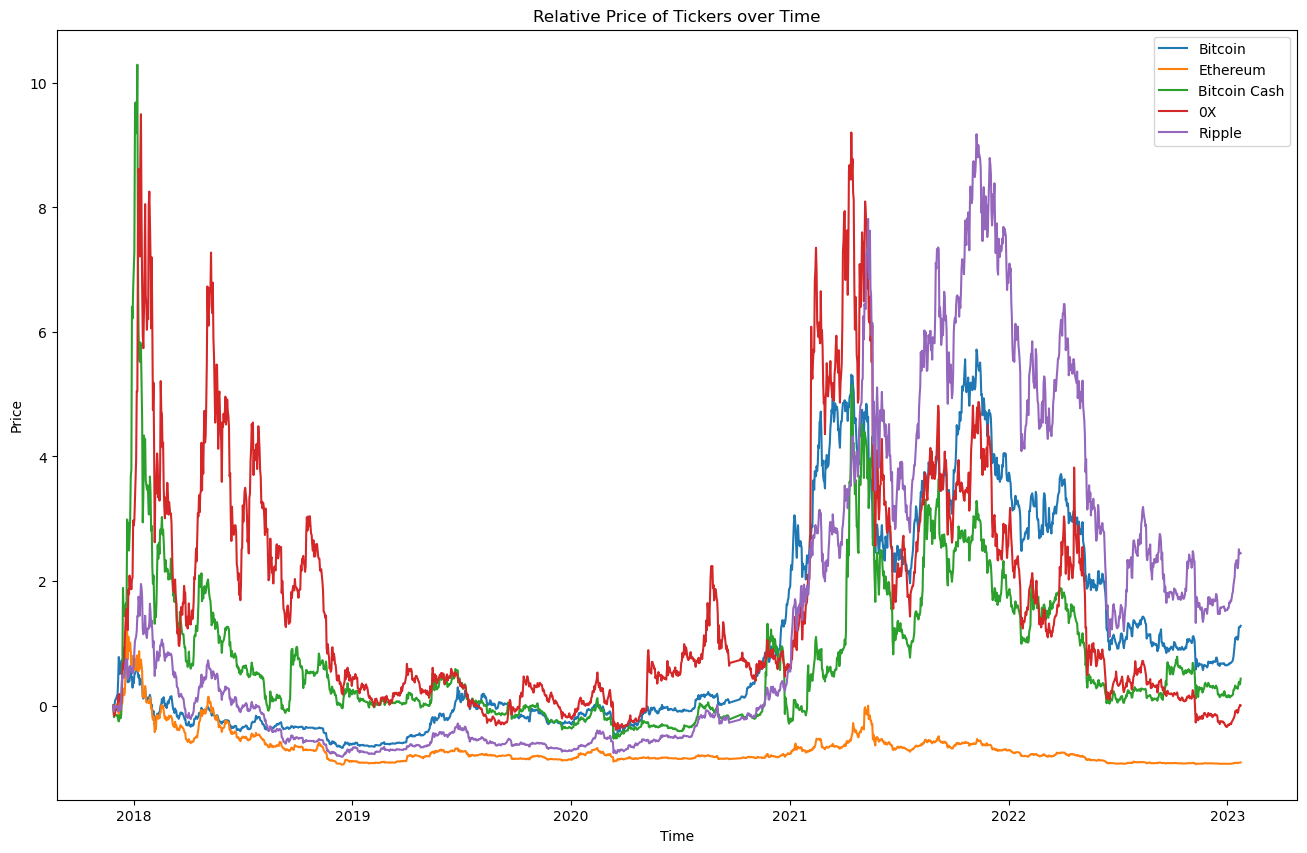

In [117]:
def plot_ticker_data(df, tickers, start=None):
    plt.figure(figsize=(16, 10))
    # df = df.query('index > "2021-04-13"')
    if start is not None:
        df = df.query('index > @start') 
    for ticker in tickers:
        
        data = df[ticker] / df[ticker][0] - 1
        plt.plot(data, label=ticker)
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Relative Price of Tickers over Time')
    plt.show()
plot_ticker_data(df, ticker_names)

# Slut på chatGPT




## Get inflation data US and SE

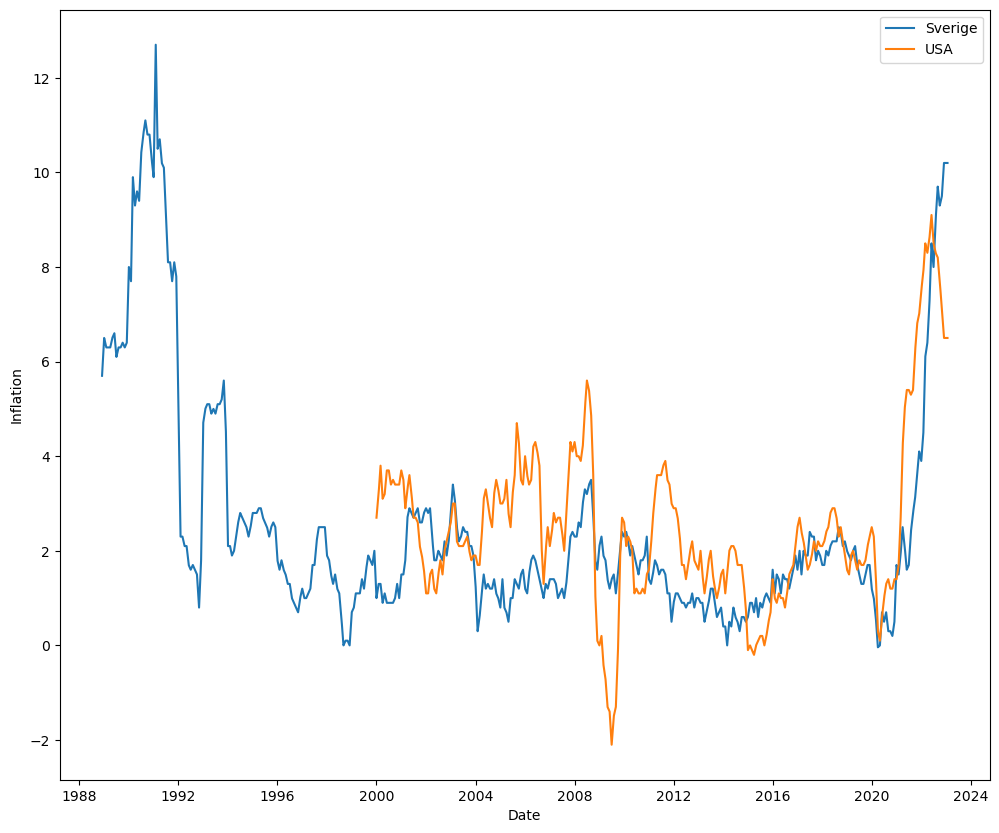

In [118]:
def add_horizon_columns(inflation, horizons):
    # print(horizons)
    for horizon in  horizons:
        # print(horizon)
        inflation['US_inflation_'+str(horizon)] = inflation['US_inflation'].rolling(horizon, 1).mean()
        inflation['SE_inflation_'+str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()
                
        # print(inflation.columns)        
    return inflation


def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['date'] = pd.to_datetime(inflation['Year'].astype(str) + '-' + inflation['month'].astype(str))
    inflation.set_index('date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(inflation, how='left', left_on='date', right_index=True)
    inflation.set_index('date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


def get_inflation_data(graph=False):
    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    #
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1)
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75,90,250])
    return inflations

inflations = get_inflation_data(graph=True)

In [119]:
list(inflations.columns)

['US_inflation',
 'SE_inflation',
 'US_inflation_75',
 'SE_inflation_75',
 'US_inflation_90',
 'SE_inflation_90',
 'US_inflation_250',
 'SE_inflation_250']

In [120]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


In [121]:
def fill_rolling(df, ticker_name, window):
    """Beräknar rolling trend för en ticker"""

    df[ticker_name+'_tr'] = df[ticker_name].fillna(method='ffill')/30   # Basvärde att räkna från
    df[ticker_name+'_'+str(window)] = df[ticker_name+'_tr'].rolling(window, 1).mean()
    # remove column
    df.drop(ticker_name+'_tr', axis=1, inplace=True)
    
    return df

## get Google Trends Crypto data


Bitcoin
Ethereum
Bitcoin Cash
0X
Ripple


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2023-01-19,0.8,0.633333,0.133333,0.033333,0.1,0.025852,0.019481,0.004444,0.002741,0.003333,0.027877,0.022420,0.004444,0.002765,0.003333,0.033298,0.031649,0.004791,0.002644,0.003409
2023-01-20,0.8,0.633333,0.133333,0.033333,0.1,0.025926,0.019630,0.004444,0.002593,0.003333,0.027901,0.022395,0.004444,0.002753,0.003333,0.033240,0.031578,0.004787,0.002627,0.003404
2023-01-21,0.8,0.633333,0.133333,0.033333,0.1,0.026000,0.019778,0.004444,0.002444,0.003333,0.027926,0.022370,0.004444,0.002741,0.003333,0.033182,0.031507,0.004782,0.002609,0.003400
2023-01-22,0.8,0.633333,0.133333,0.033333,0.1,0.026074,0.019926,0.004444,0.002296,0.003333,0.027951,0.022346,0.004444,0.002728,0.003333,0.033124,0.031436,0.004778,0.002591,0.003396
2023-01-23,0.8,0.633333,0.133333,0.033333,0.1,0.026148,0.020074,0.004444,0.002148,0.003333,0.027975,0.022321,0.004444,0.002716,0.003333,0.033067,0.031364,0.004773,0.002573,0.003391


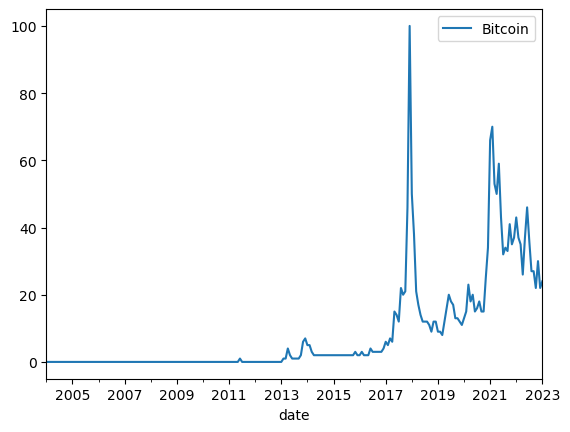

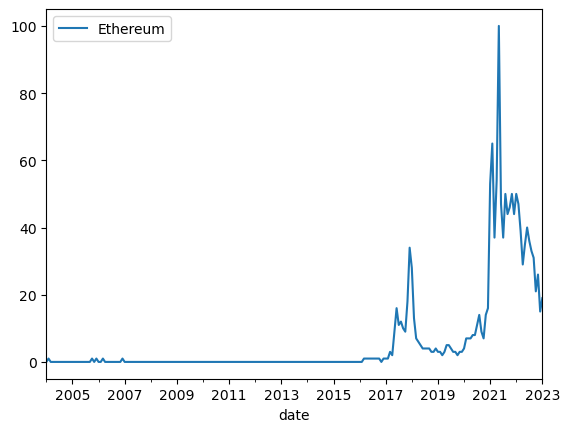

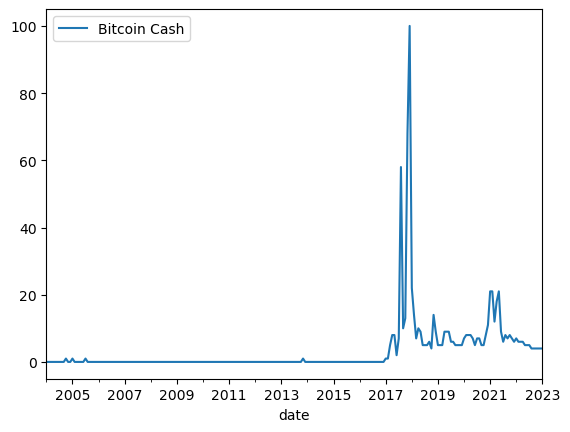

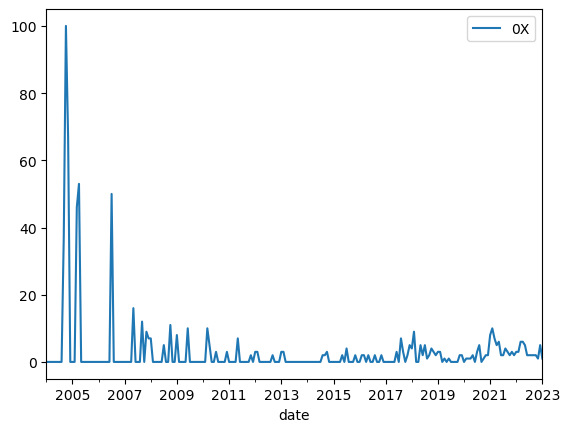

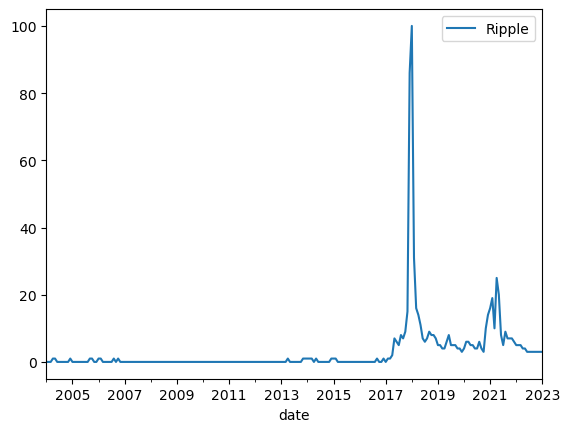

In [122]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq()
df_trend = get_all_dates()
for ticker_name in ticker_names:
    print(ticker_name)
    pytrends.build_payload(kw_list=[ticker_name], cat=7, timeframe='all')
    df_temp = pytrends.interest_over_time()
    df_temp = df_temp.drop(columns=['isPartial'])
    df_temp.plot()
    df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
    df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
    # df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
    df_trend = fill_rolling(df_trend, ticker_name, 30)
    # df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
    df_trend = fill_rolling(df_trend, ticker_name, 90)
    # df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
    df_trend = fill_rolling(df_trend, ticker_name, 250)
    
    
# gruppera kolumnerna per typ av data
df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]

df_trend.tail()


In [123]:
df_trend.to_csv('google_trends.csv')


## skapa alla modellerna

In [124]:
df_trend.query('index>"2017-01-01"').sample(6)


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2021-07-10,1.066667,1.233333,0.200000,0.066667,0.166667,0.043704,0.048519,0.008889,0.002222,0.007778,0.054185,0.072914,0.016333,0.004457,0.017099,0.054853,0.053324,0.016431,0.005684,0.016498
2019-05-06,0.533333,0.166667,0.300000,0.000000,0.200000,0.014222,0.003778,0.010000,0.000889,0.004889,0.011247,0.003099,0.007333,0.001222,0.004877,0.011556,0.003529,0.007942,0.002422,0.006951
2019-03-28,0.266667,0.066667,0.166667,0.000000,0.133333,0.008963,0.002296,0.005556,0.000222,0.004519,0.009765,0.003025,0.005704,0.002259,0.005284,0.011502,0.003662,0.007302,0.002640,0.007373
2017-10-16,0.700000,0.300000,0.433333,0.000000,0.300000,0.022815,0.010519,0.012889,0.001556,0.008963,0.021901,0.011840,0.029593,0.003790,0.008235,0.014987,0.009284,0.014427,0.001764,0.005622
2018-02-27,1.266667,0.433333,0.466667,0.300000,1.033333,0.043556,0.016111,0.016444,0.009444,0.042111,0.070642,0.028284,0.052198,0.006469,0.081704,0.042102,0.018813,0.039707,0.004058,0.035524
2018-05-31,0.466667,0.166667,0.300000,0.166667,0.366667,0.015556,0.005556,0.010000,0.005556,0.012222,0.019173,0.006642,0.009654,0.001914,0.015123,0.042133,0.016564,0.033258,0.003409,0.038529


In [125]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [126]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [127]:
display(df_org.isna().sum())
display(df_org.head())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1081
XRP-USD    1149
dtype: int64

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD
Date,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN
2014-09-18,424.440002,NaN,NaN,NaN,NaN
2014-09-19,394.795990,NaN,NaN,NaN,NaN
2014-09-20,408.903992,NaN,NaN,NaN,NaN
2014-09-21,398.821014,NaN,NaN,NaN,NaN


(3051, 5)

In [128]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



Backtest av modellerna

In [129]:
def backtest(data, target, model, predictors, gap=0, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        taregt (str): Name of the target column
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []
    print('last date', (data.iloc[-1].name).date())
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[(i+gap):(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [130]:
def add_predictors(df_, ticker, target, horizons=[2,5,60,250], ETH_BTC=False):
    df = df_.copy()
    ticker_name = ticker[:3]
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    predictors=[]
     
    if ETH_BTC: 
        df['ETH_BTC_ratio'] = df['ETH-USD']/df['BTC-USD']
        predictors += ['ETH_BTC_ratio']
        
        df['ETH_BTC_lag1'] = df['ETH_BTC_ratio'].shift(1)
        predictors += ['ETH_BTC_lag1']
        
        df['ETH_BTC_lag2'] = df['ETH_BTC_ratio'].shift(2)
        predictors += ['ETH_BTC_lag2']
        
        if ticker not in ['BTC-USD', 'ETH-USD']:
            df[ticker_name+'_BTC_ratio'] = df[ticker]/df['BTC-USD']
            predictors += [ticker_name+'_BTC_ratio']
        
            df[ticker_name+'_BTC_lag1'] = df[ticker_name+'_BTC_ratio'].shift(1)
            predictors += [ticker_name+'_BTC_lag1']
            
            df[ticker_name+'_BTC_lag2'] = df[ticker_name+'_BTC_ratio'].shift(2)
            predictors += [ticker_name+'_BTC_lag2']
            
            df[ticker_name+'_ETH_ratio'] = df[ticker]/df['ETH-USD']
            predictors += [ticker_name+'_ETH_ratio']
        
            df[ticker_name+'_ETH_lag1'] = df[ticker_name+'_ETH_ratio'].shift(1)
            predictors += [ticker_name+'_ETH_lag1']
            
            df[ticker_name+'_ETH_lag2'] = df[ticker_name+'_ETH_ratio'].shift(2)
            predictors += [ticker_name+'_ETH_lag2']
            
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        # edit_column = f"edit_{horizon}"
        # df[edit_column] = rolling_averages['edit_count']
        ## Den ovan ändras till min Google Trends och görs på annan plats
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]     #### OBS! Skilj trend_column från Google Trends

        predictors += [ratio_column, trend_column]

    df['day_of_month'] = df.index.day
    predictors += ['day_of_month']
    
    df['day_of_week'] = df.index.dayofweek
    predictors += ['day_of_week']
    
    df['month'] = df.index.month
    predictors += ['month']

    predictors += ['stoch_k']
    # df = df.dropna()
    return df, predictors


In [131]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
# print(tickers[0])
# df, predictors = add_predictors(df_org, tickers[0], 'y1')
# df[predictors+['y1']]


### Vi använder XGBoost / CatBoost

Loop öve all tickers och skapa 2 modeller  
    En mot y1 (tomorrow) och en mot y2 (day after tomorrow)  
    spara båda modellerna  
Totalt 2 modeller per ticker    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [132]:
def add_google_trends(df_, df_trend, ticker, predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    predictors.append(ticker_namn + '_goog250')
    
    return df, predictors


##### Generate all xgbModels and save them #####
def generate_all_xgbmodels(df_org, tickers, horizons=[2, 5, 30, 60, 250], save=True, remove=[], ETH_BTC=False, use_inflations=True):
    xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
    precision_list=[]
    
    df_inflations = get_inflation_data(graph=False)
    for ticker in tickers:
        namn = ticker[:3]
        print(namn+'1')
        target = 'y1'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y1'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_xgb = backtest(df, target, model, predictors, proba_val= 0.55, step=30)

        precision_list.append((namn+'1', print_results(predictions_xgb, target)))

        # display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=predictors).sort_values(by='importance', ascending=False))
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind='bar', title=namn+'1' , figsize=(18, 10)).get_figure())
        plt.show( )
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        # display(predictors)
        if save:
            model.save_model(f'{namn}_{target}.json')


        print(namn+'2')
        target='y2'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y2'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_xgb = backtest(df, target, model, predictors, proba_val=0.55, step=30)

        precision_list.append((namn+'2',print_results(predictions_xgb, target)))
        
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind = 'bar', title=namn+'2', figsize = (18, 10)).get_figure())
        plt.show()
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        if save:
            model.save_model(f'{namn}_{target}.json')
        
    return precision_list,predictors


In [ ]:
##### Generate all catModels and save them #####


#####################################
#####    OBS OBS OBS OBS OBS    #####
#####    DENNA ÄR INTE KLAR     #####
#####################################
def generate_all_catmodels(df_org, tickers, horizons=[2, 5, 30, 60, 250], save=True, remove=[], ETH_BTC=False, use_inflations=True):
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')

    
    cat_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
    precision_list=[]
    
    df_inflations = get_inflation_data(graph=False)
    for ticker in tickers:
        namn = ticker[:3]
        print(namn+'1')
        target = 'y1'
        model = CatBoostClassifier(**cat_params,  random_state=2022, n_jobs=-1)
        df, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y1'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_cat = backtest(df, target, model, predictors, proba_val= 0.55, step=30)

        precision_list.append((namn+'1', print_results(predictions_cat, target)))

        # display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=predictors).sort_values(by='importance', ascending=False))
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind='bar', title=namn+'1' , figsize=(18, 10)).get_figure())
        plt.show( )
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = CatBoostClassifier(early_stopping_rounds=100, 
                                **cat_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        # display(predictors)
        if save:
            model.save_model(f'{namn}_{target}.json')


        print(namn+'2')
        target='y2'
        model = CatBoostClassifier(**cat_params,  random_state=2022, n_jobs=-1)
        df, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y2'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_cat = backtest(df, target, model, predictors, proba_val=0.55, step=30)

        precision_list.append((namn+'2',print_results(predictions_cat, target)))
        
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind = 'bar', title=namn+'2', figsize = (18, 10)).get_figure())
        plt.show()
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = CatBoostClassifier(early_stopping_rounds=100, 
                                **cat_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        if save:
            model.save_model(f'{namn}_{target}.json')
        
    return precision_list,predictors

In [133]:
###### tester ######

ticker=tickers[0]
target='y1'
horizons = [2, 5, 30, 60, 250]

df_inflations = get_inflation_data(graph=False)
df_test, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=True)
df_test, predictors = add_google_trends(df_test, df_trend, ticker, predictors)

df_test = pd.concat([df_test, df_inflations], axis=1)
predictors += list(df_inflations.columns)
df_test.dropna(subset=['y1'], inplace=True)
    


In [135]:
df_test[predictors]

,ETH_BTC_ratio,ETH_BTC_lag1,ETH_BTC_lag2,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_30,Trend_30,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,day_of_month,day_of_week,month,stoch_k,Bitcoin_goog30,Bitcoin_goog90,Bitcoin_goog250,US_inflation,SE_inflation,US_inflation_75,SE_inflation_75,US_inflation_90,SE_inflation_90,US_inflation_250,SE_inflation_250
2014-09-17,NaN,NaN,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,17.0,2.0,9.0,NaN,0.0022,0.0022,0.0030,1.7,0.46,1.7488,0.4491,1.7924,0.4789,1.7769,0.4432
2014-09-18,NaN,NaN,NaN,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,18.0,3.0,9.0,NaN,0.0022,0.0022,0.0030,1.7,0.47,1.7453,0.4475,1.7887,0.4766,1.7779,0.4435
2014-09-19,NaN,NaN,NaN,0.9638,409.6180,0.9278,409.6180,0.9278,409.6180,0.9278,409.6180,0.9278,409.6180,19.0,4.0,9.0,NaN,0.0022,0.0022,0.0030,1.7,0.48,1.7419,0.4461,1.7850,0.4746,1.7791,0.4438
2014-09-20,NaN,NaN,NaN,1.0176,401.8500,0.9704,409.3800,0.9704,409.3800,0.9704,409.3800,0.9704,409.3800,20.0,5.0,9.0,NaN,0.0022,0.0022,0.0030,1.7,0.49,1.7387,0.4449,1.7813,0.4727,1.7802,0.4442
2014-09-21,NaN,NaN,NaN,0.9875,403.8625,0.9567,406.7402,0.9567,406.7402,0.9567,406.7402,0.9567,406.7402,21.0,6.0,9.0,NaN,0.0022,0.0022,0.0030,1.7,0.50,1.7356,0.4439,1.7777,0.4710,1.7815,0.4446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19,0.0736,0.0733,0.0741,1.0095,20887.7871,1.0043,20997.5051,1.1799,17870.9617,1.2143,17365.0671,1.0120,20835.7695,19.0,3.0,1.0,0.5904,0.0259,0.0279,0.0333,6.5,10.20,6.5867,10.0989,6.6818,9.9977,7.7223,9.2799
2023-01-20,0.0732,0.0736,0.0733,1.0363,21881.6729,1.0618,21356.6559,1.2552,18066.2623,1.2973,17479.8882,1.0902,20801.2552,20.0,4.0,1.0,0.4671,0.0259,0.0279,0.0332,6.5,10.20,6.5800,10.1067,6.6730,10.0062,7.7130,9.2896
2023-01-21,0.0714,0.0732,0.0736,1.0022,22727.0889,1.0507,21678.2543,1.2471,18264.5051,1.2949,17589.6858,1.0965,20772.9141,21.0,5.0,1.0,0.5101,0.0260,0.0279,0.0332,6.5,10.20,6.5736,10.1141,6.6644,10.0146,7.7037,9.2991
2023-01-22,0.0717,0.0714,0.0732,0.9987,22749.0205,1.0332,21990.0336,1.2307,18461.9538,1.2843,17691.5143,1.0954,20742.0923,22.0,6.0,1.0,0.5471,0.0261,0.0280,0.0331,6.5,10.20,6.5675,10.1213,6.6560,10.0230,7.6942,9.3084


BTC1
last date 2023-01-23
Fördelning av y1: 1 vs 0:
1.0    0.5403
0.0    0.4597
Name: y1, dtype: float64
y1   Predictions
1.0  0              1050
0.0  0               938
1.0  1               404
0.0  1               299
dtype: int64
Precision:	0.5747
Figure(1800x1000)


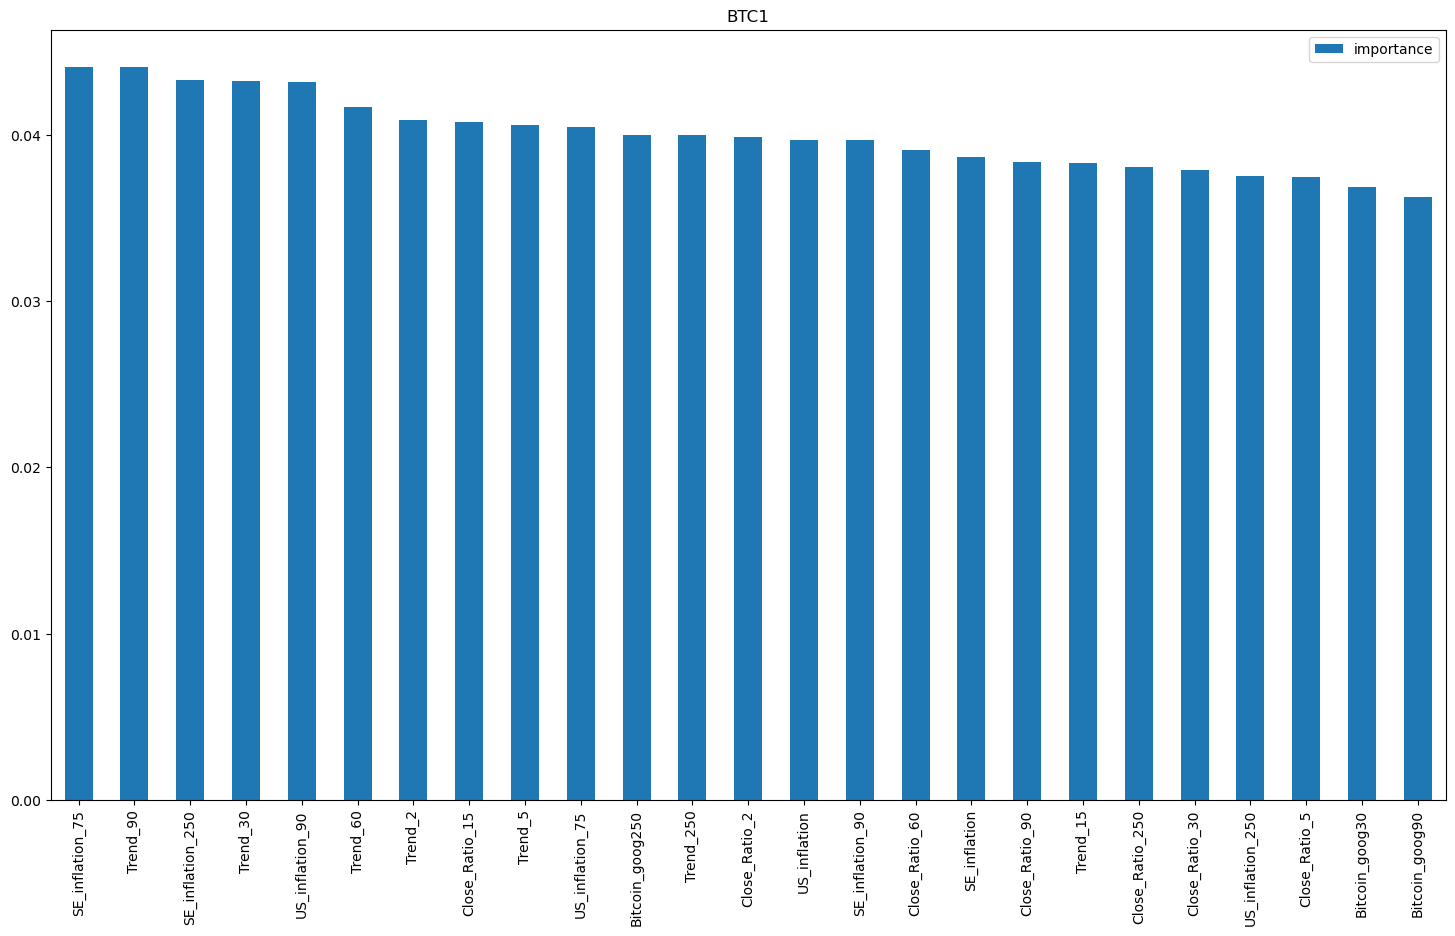

BTC2
last date 2023-01-23
Fördelning av y2: 1 vs 0:
1.0    0.5548
0.0    0.4452
Name: y2, dtype: float64
y2   Predictions
1.0  0              993
0.0  0              796
1.0  1              500
0.0  1              402
dtype: int64
Precision:	0.5543
Figure(1800x1000)


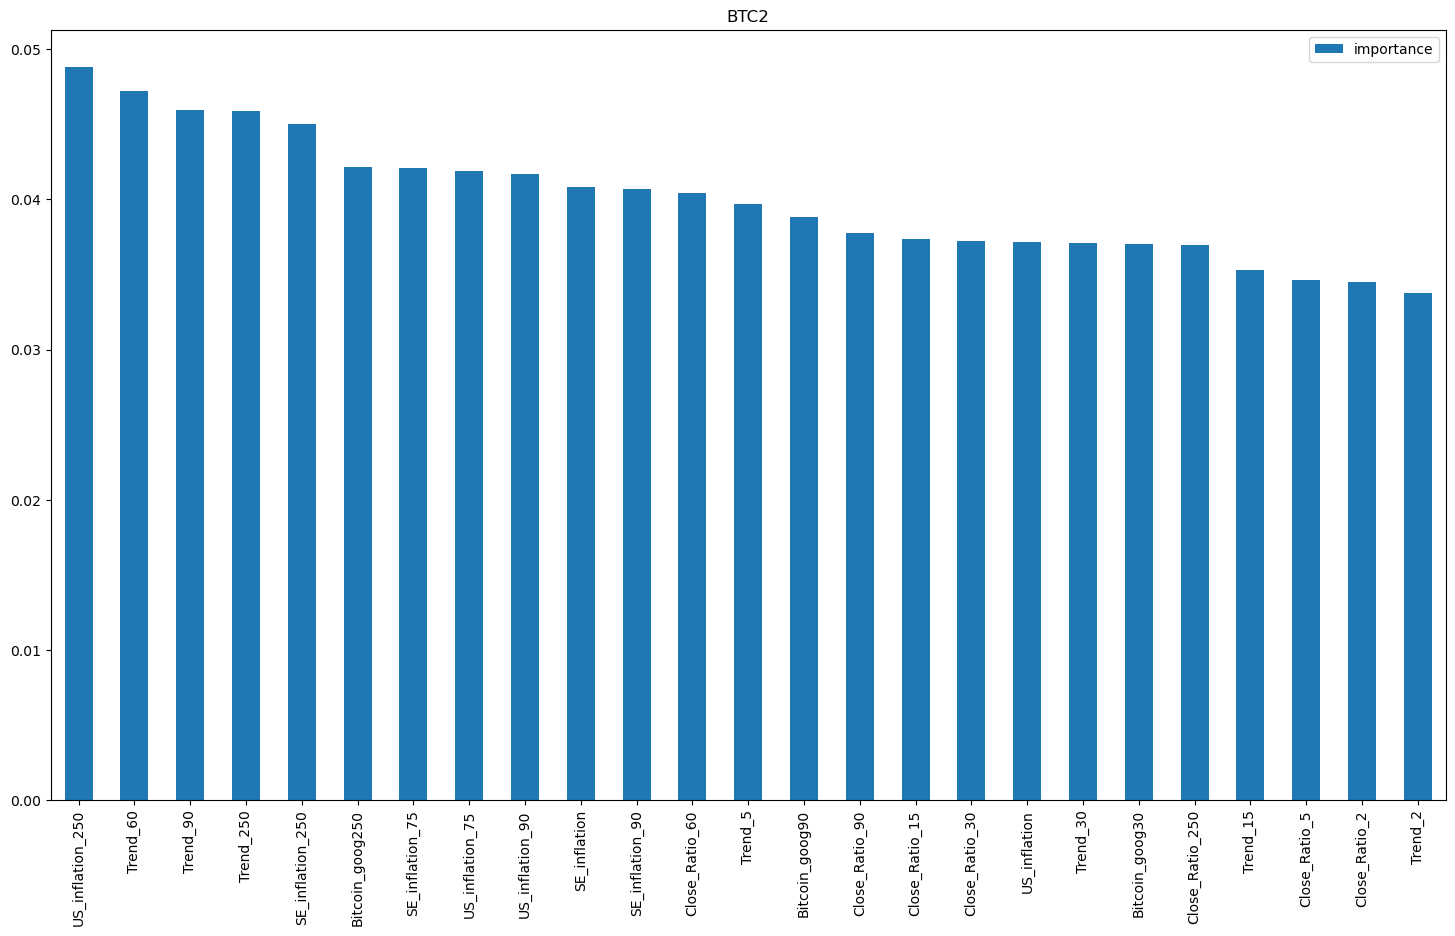

ETH1
last date 2023-01-23
Fördelning av y1: 1 vs 0:
0.0    0.6362
1.0    0.3638
Name: y1, dtype: float64
y1   Predictions
0.0  0              1507
1.0  0               751
     1               228
0.0  1               205
dtype: int64
Precision:	0.5266
Figure(1800x1000)


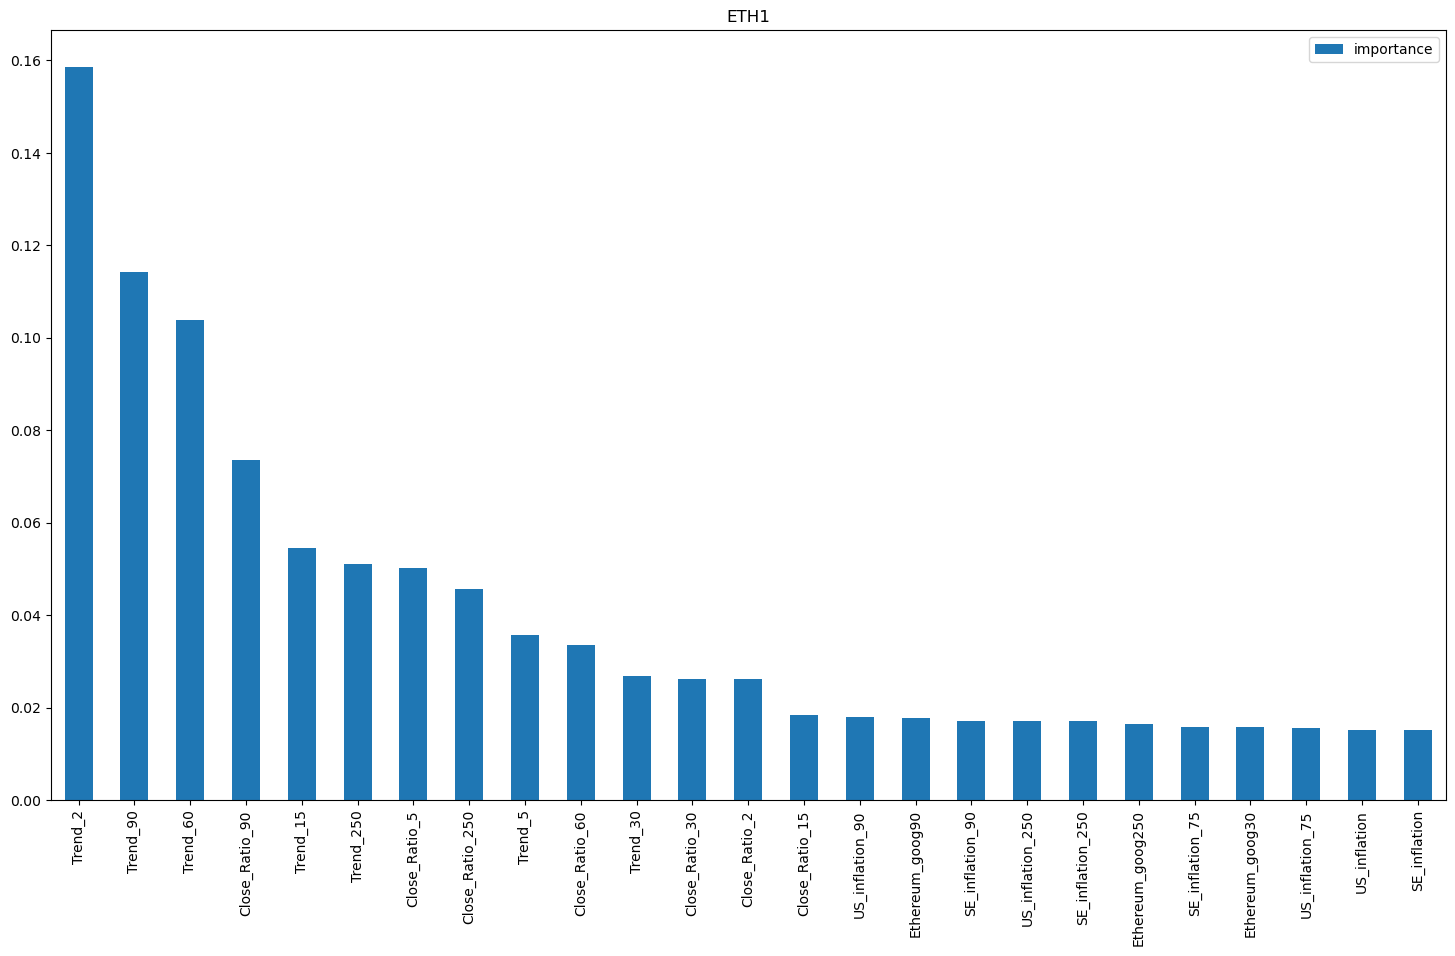

ETH2
last date 2023-01-23
Fördelning av y2: 1 vs 0:
0.0    0.6343
1.0    0.3657
Name: y2, dtype: float64
y2   Predictions
0.0  0              1438
1.0  0               756
0.0  1               269
1.0  1               228
dtype: int64
Precision:	0.4588
Figure(1800x1000)


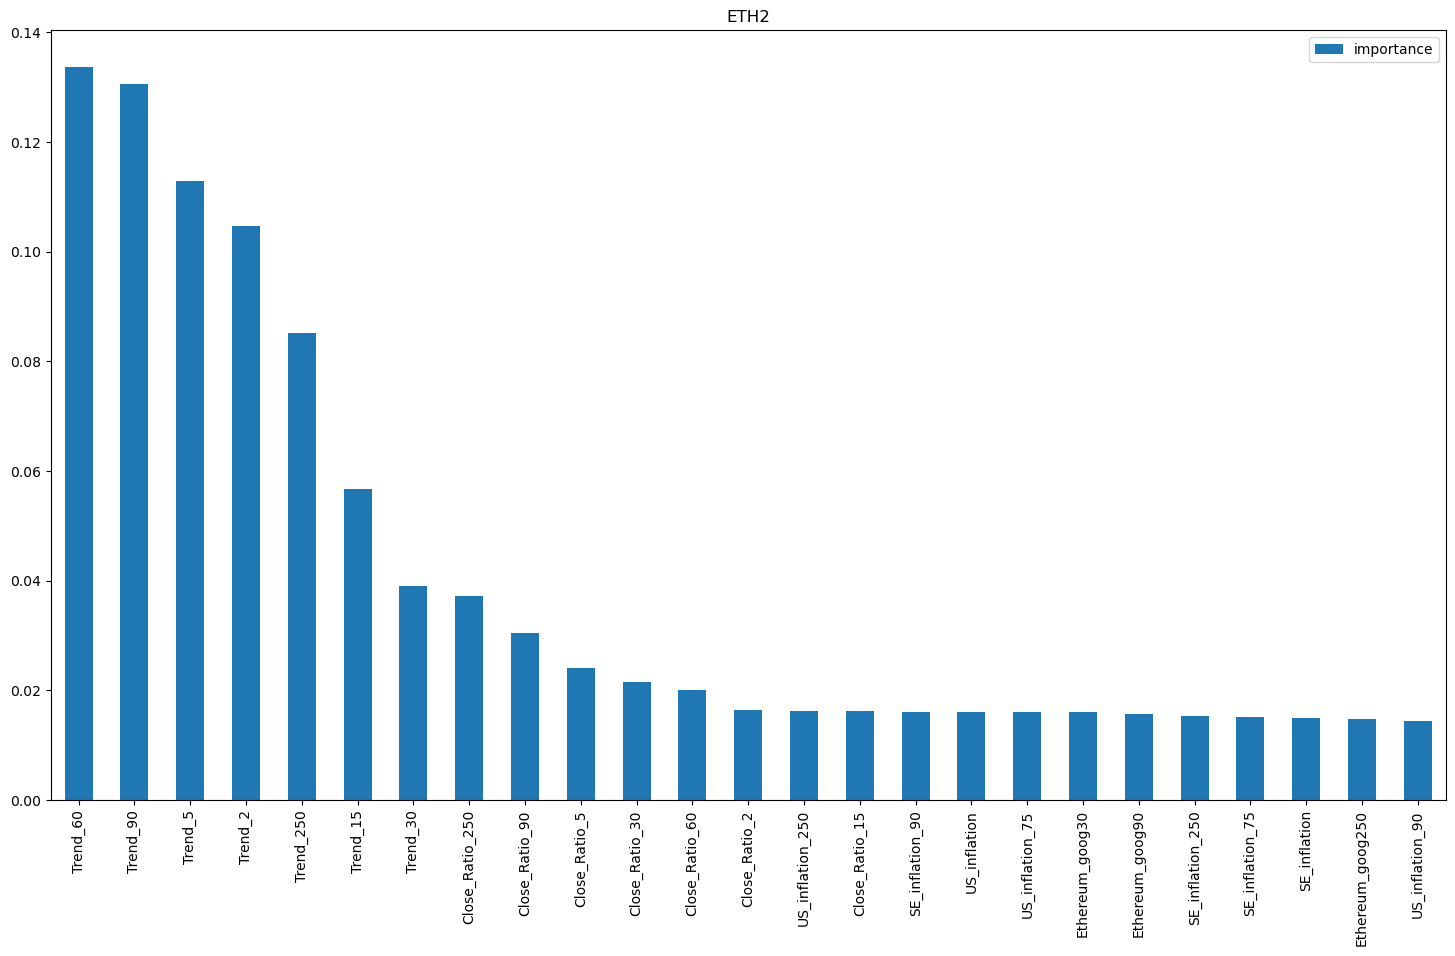

BCH1
last date 2023-01-23
Fördelning av y1: 1 vs 0:
0.0    0.6566
1.0    0.3434
Name: y1, dtype: float64
y1   Predictions
0.0  0              1567
1.0  0               710
     1               214
0.0  1               200
dtype: int64
Precision:	0.5169
Figure(1800x1000)


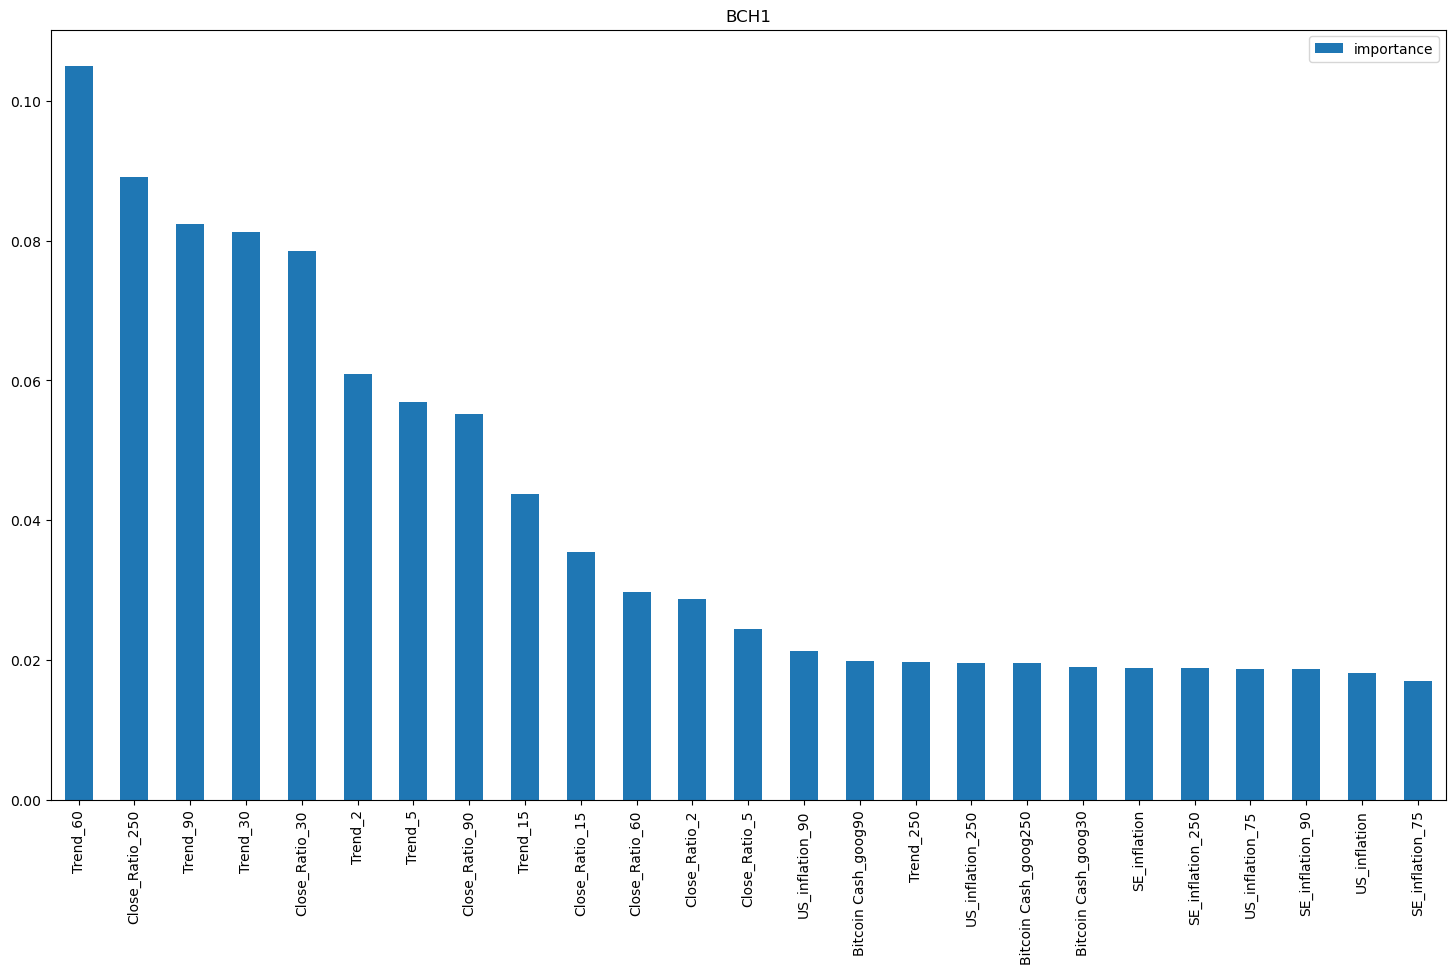

BCH2
last date 2023-01-23
Fördelning av y2: 1 vs 0:
0.0    0.6622
1.0    0.3378
Name: y2, dtype: float64
y2   Predictions
0.0  0              1595
1.0  0               717
     1               192
0.0  1               187
dtype: int64
Precision:	0.5066
Figure(1800x1000)


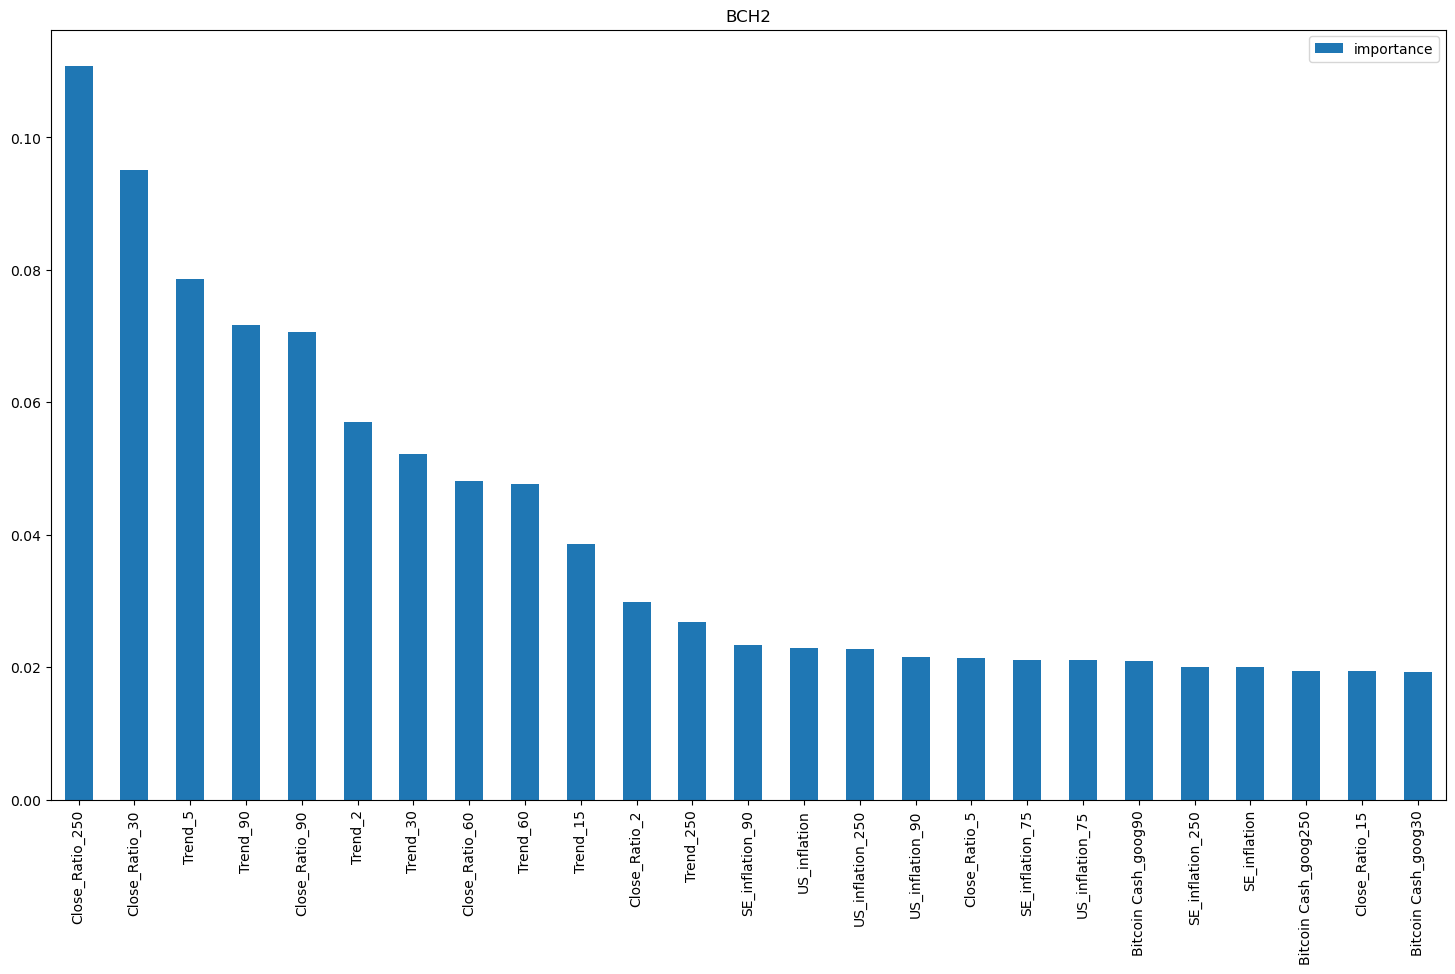

ZRX1
last date 2023-01-23
Fördelning av y1: 1 vs 0:
0.0    0.6407
1.0    0.3593
Name: y1, dtype: float64
y1   Predictions
0.0  0              1575
1.0  0               797
     1               170
0.0  1               149
dtype: int64
Precision:	0.5329
Figure(1800x1000)


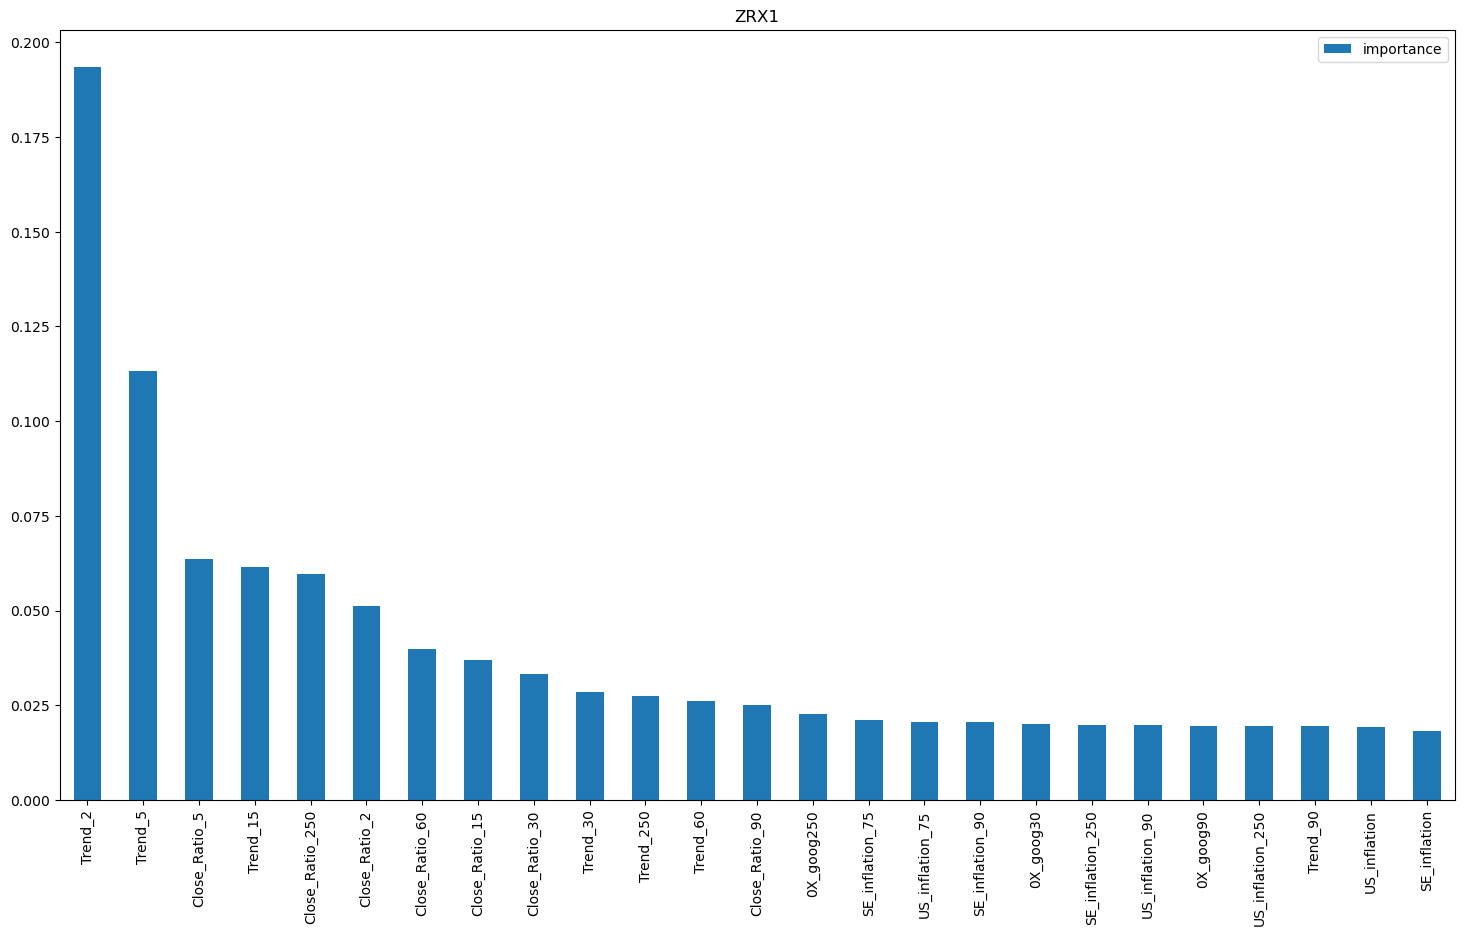

ZRX2
last date 2023-01-23
Fördelning av y2: 1 vs 0:
0.0    0.6473
1.0    0.3527
Name: y2, dtype: float64
y2   Predictions
0.0  0              1533
1.0  0               765
0.0  1               209
1.0  1               184
dtype: int64
Precision:	0.4682
Figure(1800x1000)


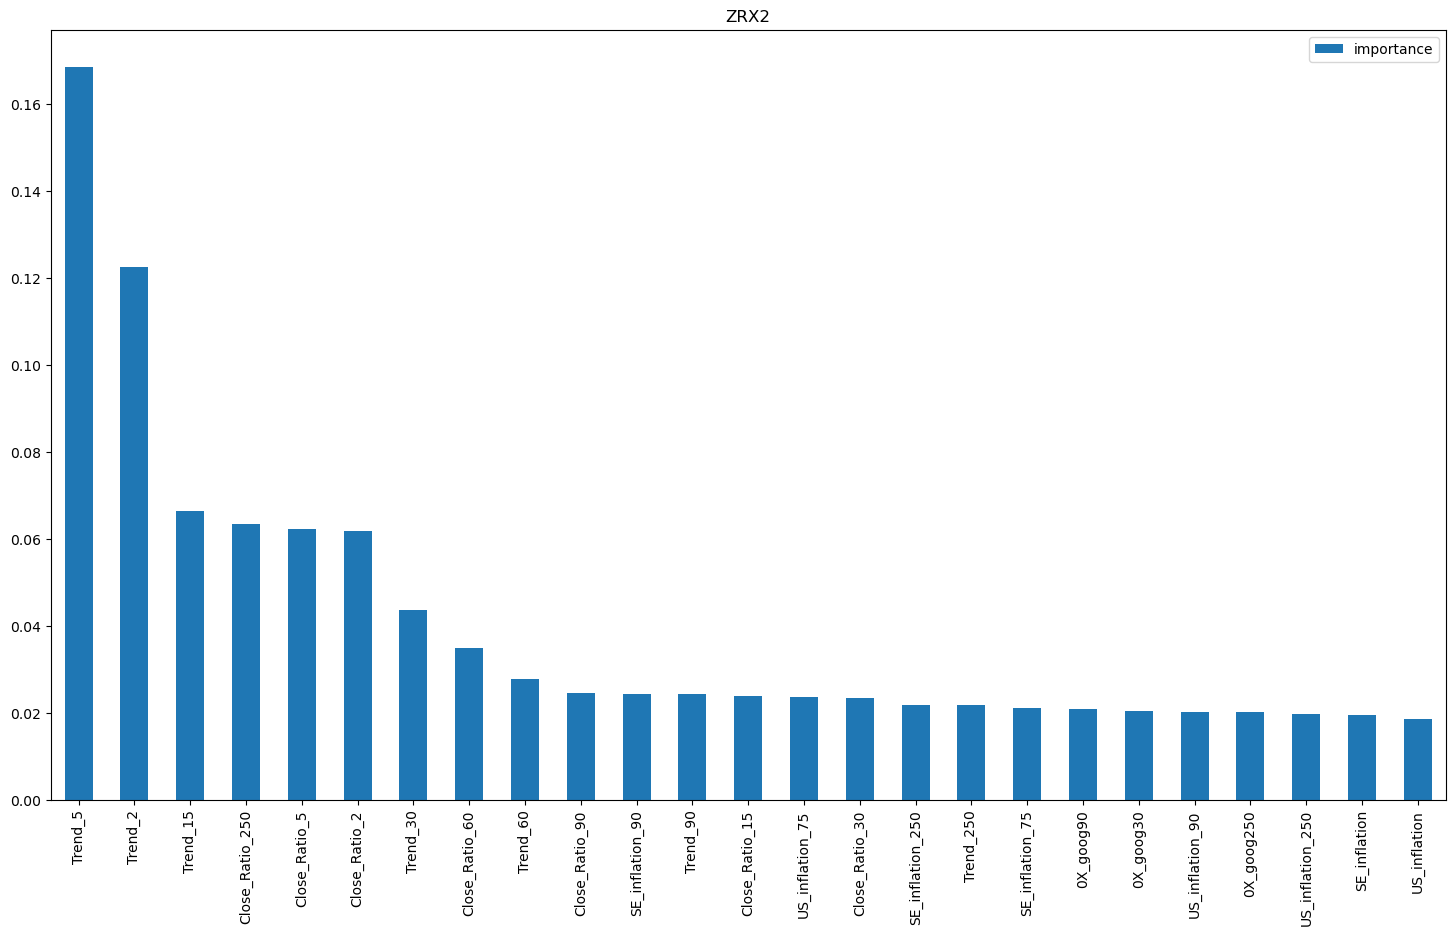

XRP1
last date 2023-01-23
Fördelning av y1: 1 vs 0:
0.0    0.6522
1.0    0.3478
Name: y1, dtype: float64
y1   Predictions
0.0  0              1575
1.0  0               720
     1               216
0.0  1               180
dtype: int64
Precision:	0.5455
Figure(1800x1000)


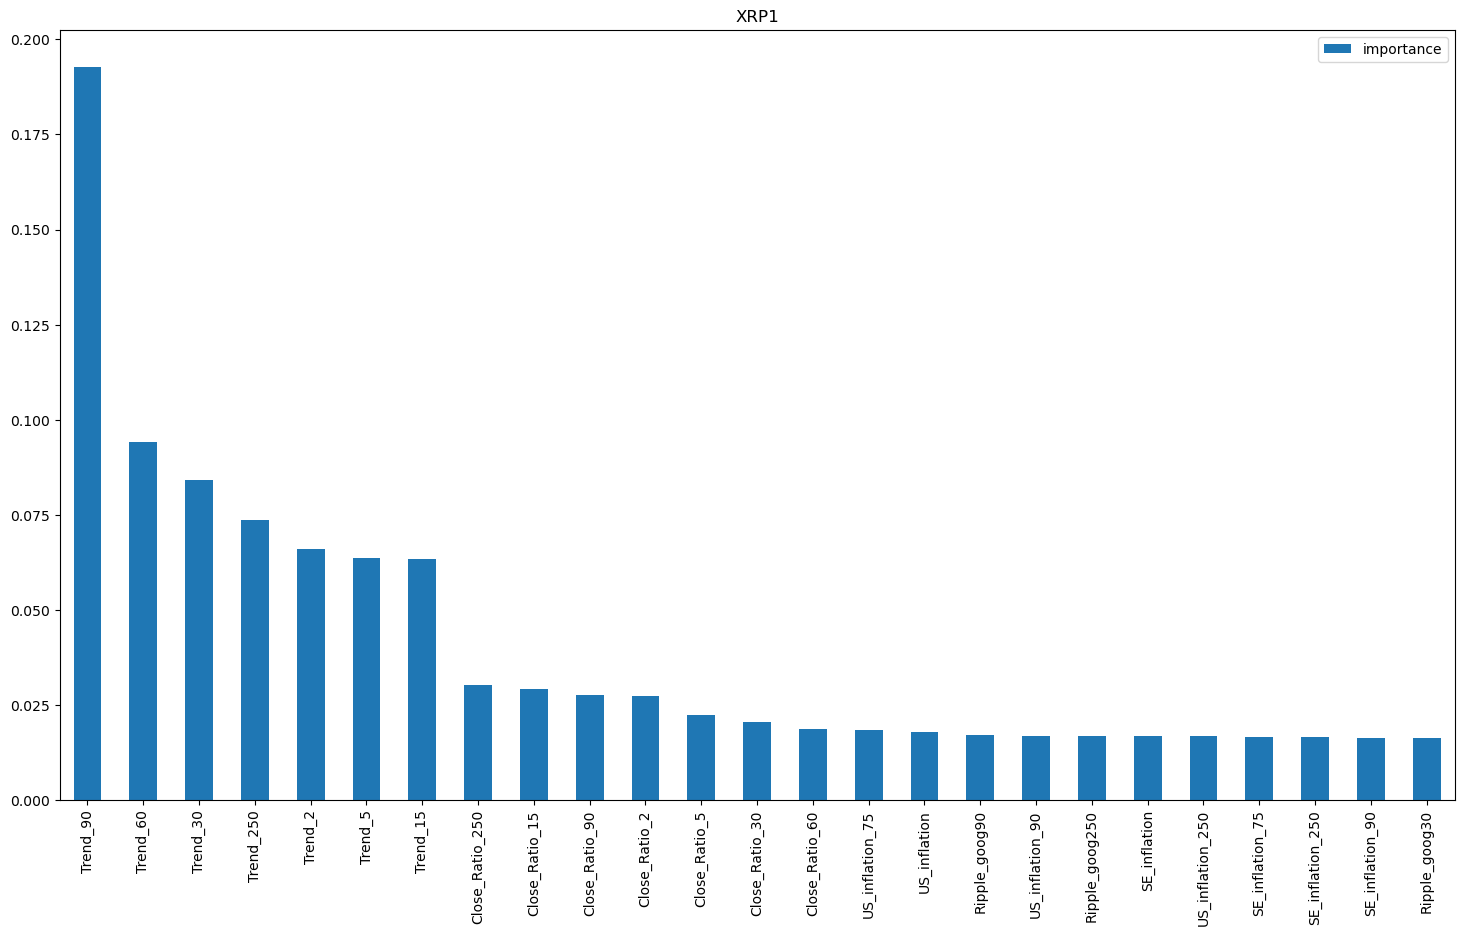

XRP2
last date 2023-01-23
Fördelning av y2: 1 vs 0:
0.0    0.6648
1.0    0.3352
Name: y2, dtype: float64
y2   Predictions
0.0  0              1612
1.0  0               736
0.0  1               177
1.0  1               166
dtype: int64
Precision:	0.4840
Figure(1800x1000)


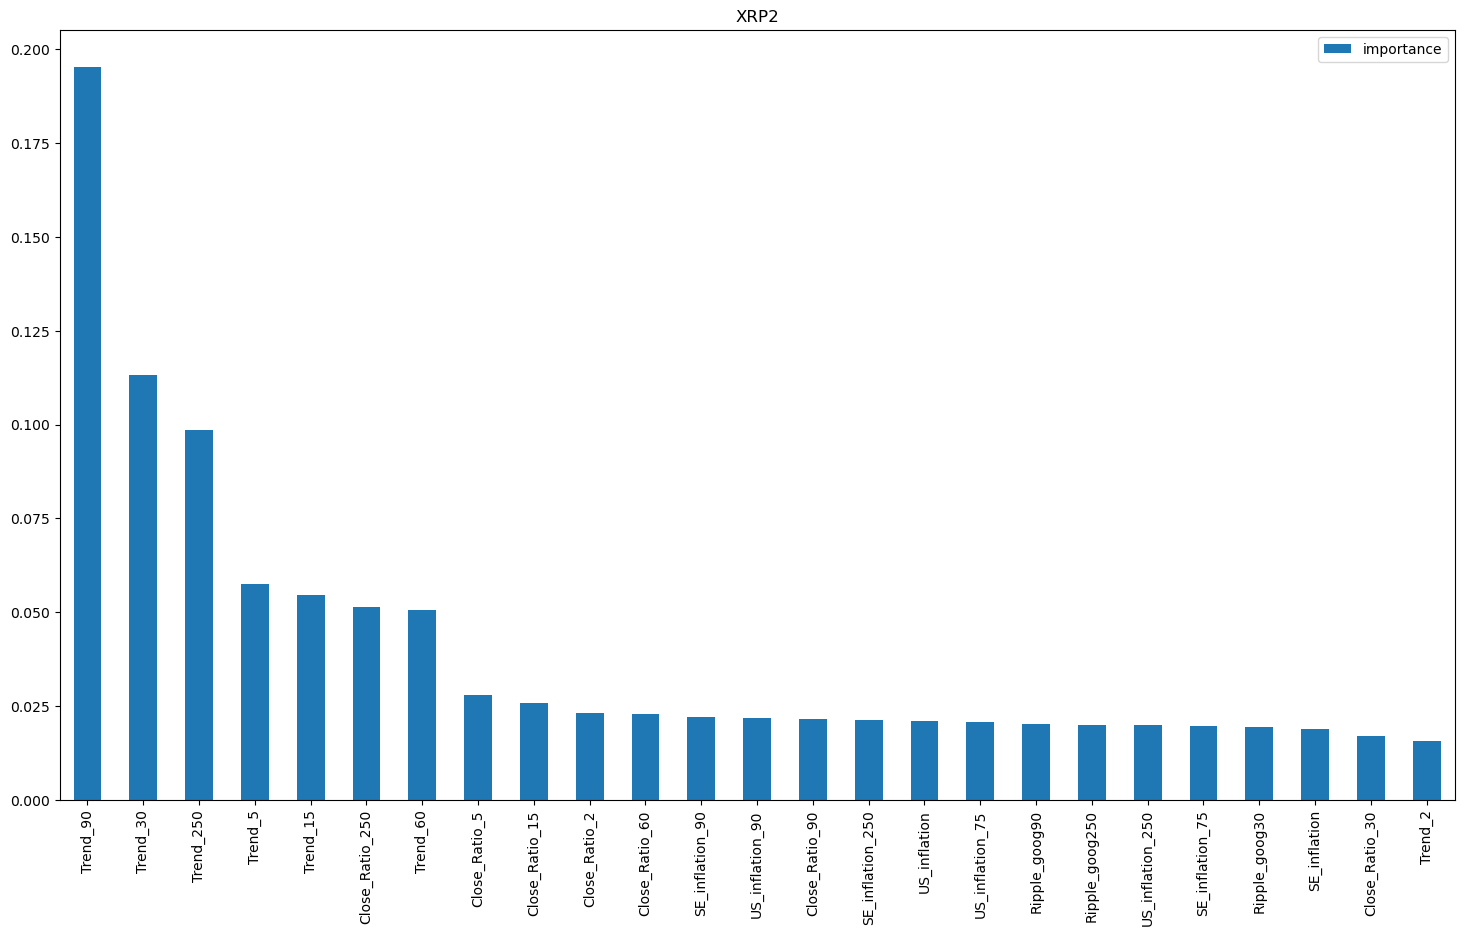

In [136]:
horizons=[2,5,15,30,60,90,250]
precision_list, predictors = generate_all_xgbmodels(df_org, tickers, horizons=horizons, save=True, remove=['month','stoch_k','day_of_week','day_of_month'], use_inflations=True)

'bad precision:'

,precision
XRP2,0.4840
ZRX2,0.4682
ETH2,0.4588


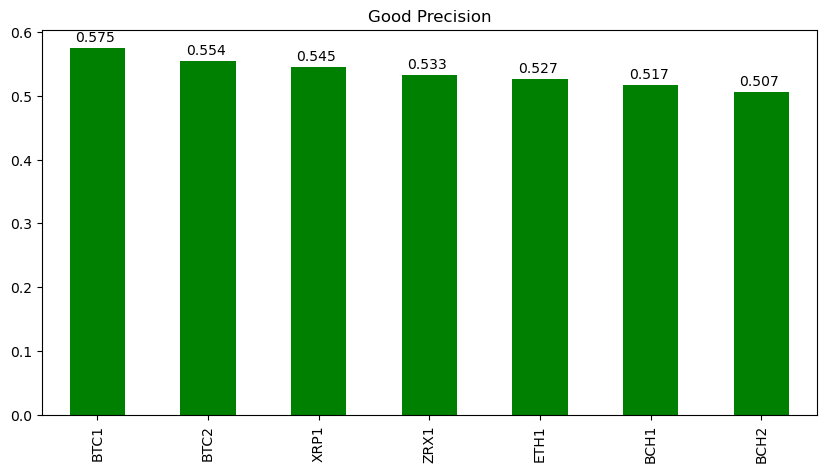

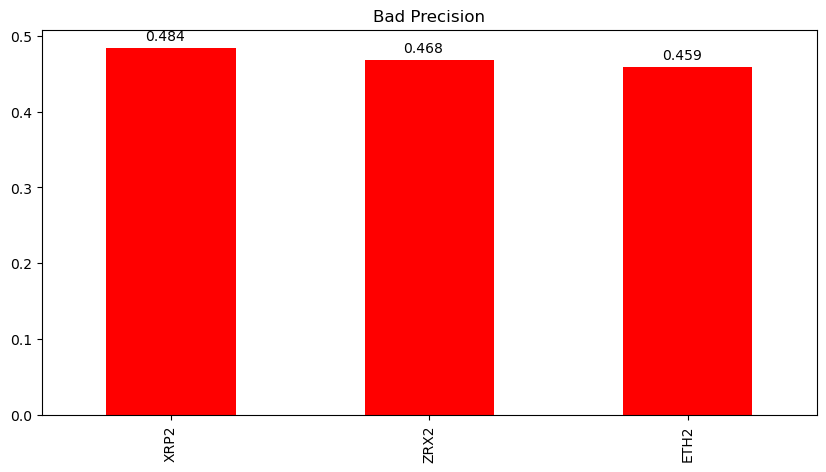

In [137]:

df_precision = pd.DataFrame(dict(precision_list), index=['precision']).T
df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title = 'Good Precision', color='green', legend=False)
# plot values in bars
for i, v in enumerate(df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).values):
    plt.text(i-0.2, v+0.01, str(round(v[0],3)))
try:
    df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).plot(kind='bar',  figsize=(10,5), title='Bad Precision',color='red', legend=False)
    # plot values in bars
    for i, v in enumerate(df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).values):
        plt.text(i-0.1, v+0.01, str(round(v[0],3)))
except IndexError:
    print('No bad precision!')

display('bad precision:',df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False))
df_precision.to_csv('precision_lags_and_ratio_no_month_stochk_15_90.csv')
# df

In [138]:
# sort the list
precision_list.sort(key=lambda x: x[1], reverse=True)
precision_list
df_precision

,precision
BTC1,0.5747
BTC2,0.5543
ETH1,0.5266
ETH2,0.4588
BCH1,0.5169
BCH2,0.5066
ZRX1,0.5329
ZRX2,0.4682
XRP1,0.5455
XRP2,0.4840


Figure(1800x1000)


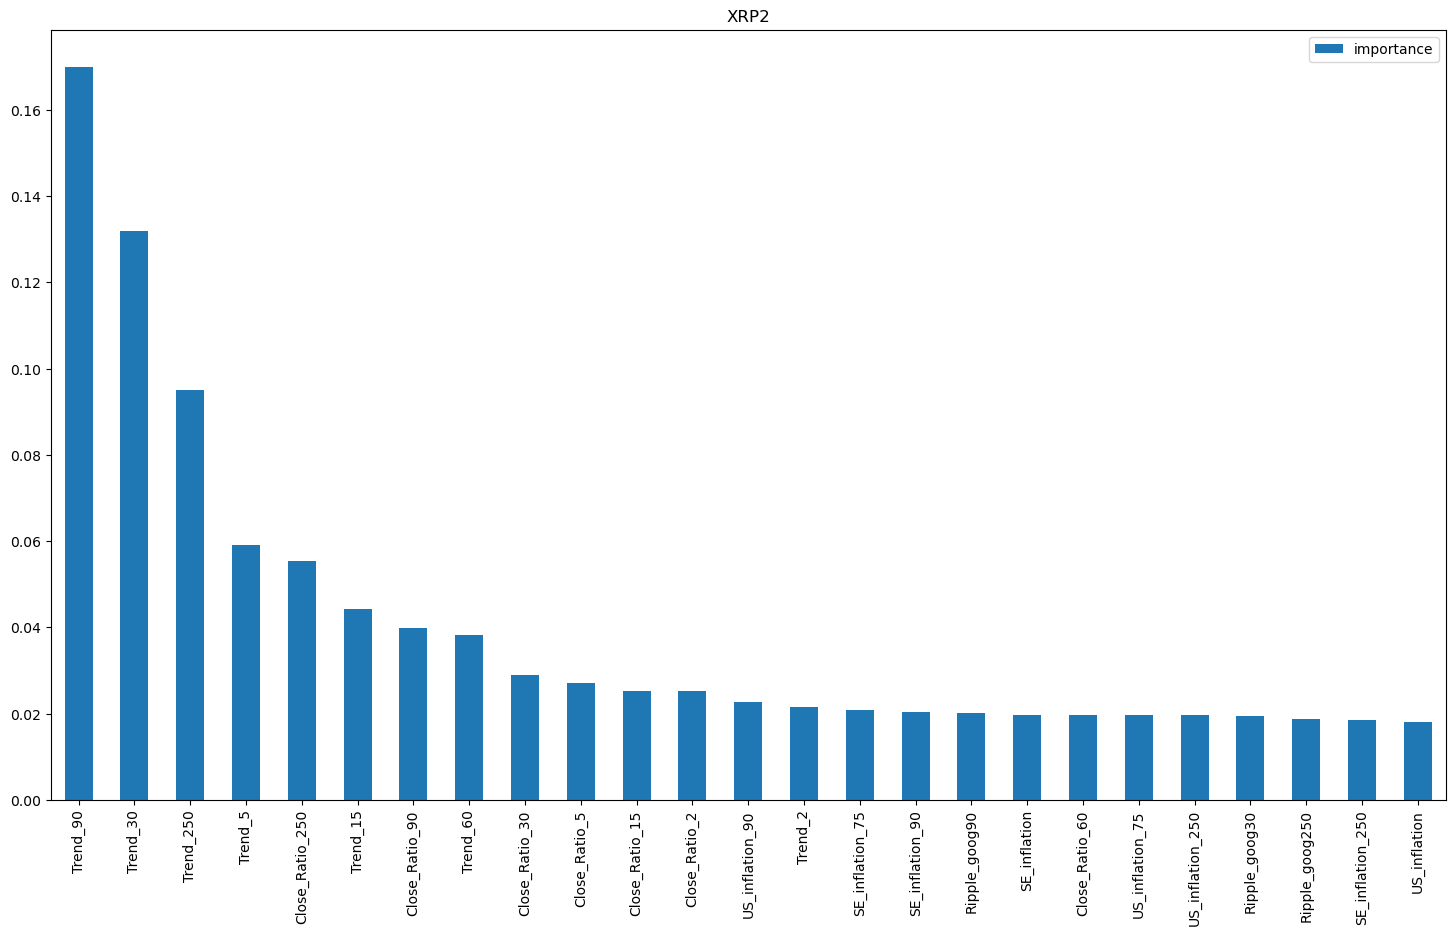

In [139]:
# horizons = [2, 5, 15, 30, 60, 90, 250]
# df, predictors = add_predictors(df_org, tickers[0], 'y1', horizons=horizons)
# df, predictors = add_google_trends(df, df_trend, tickers[0], predictors)
# df['BTC_lag1'] = df['BTC-USD'].shift(1)
# df['BTC_lag_2'] = df['BTC-USD'].shift(2)
# df['ETH_lag_1'] = df['ETH-USD'].shift(1)
# df['ETH_lag_2'] = df['ETH-USD'].shift(2)
# display(predictors)
# df[predictors]
model = xgb.XGBClassifier()
model.load_model('XRP_y2.json')
df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
print(df_imp.plot(kind = 'bar', title='XRP'+'2', figsize = (18, 10)).get_figure())
plt.show()
        

Kollar TimeSeriesSplit Cross Validation  
Jag gillar min egen backtest-variant bätte   
- Den har start vilket garanterar att första Train-datat inte är för litet  
- Den har step-size i stället för n_splits vilka ger samma index-värden om så önskas  
- Båda har gap 

In [ ]:
horizons=[2,5,15,30,60,90,250]
df, predictors = add_predictors(df_org, tickers[0], 'y1', horizons=horizons)
df, predictors = add_google_trends(df, df_trend, tickers[0], predictors)

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10,gap=1)
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index[0], '-', train_index[-1], "\nTEST:", test_index[0], '-', test_index[-1])
    # X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    # y_train, y_test = df.iloc[train_index], df.iloc[test_index]


### Test plotly

In [ ]:
df.columns

In [ ]:
df[['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD','Tomorrow','After_tomorrow', 'Trend_2', 'Trend_5', 'Close_Ratio_2']]

In [ ]:
# compute relative development
def rel_dev(df_ticker_):
    df_ticker = df_ticker_.copy()
    df_ticker = df_ticker/df_ticker.shift(1)-1
    df_ticker = df_ticker.dropna()
    just = df_ticker.head(1).values[0]
    df_ticker -= just
    return df_ticker

BTC = df[['BTC-USD']].query('index >= "2022-01-01"'); ETH = df[['ETH-USD']].query('index >= "2022-01-01"'); BCH = df[['BCH-USD']].query('index >= "2022-01-01"'); ZRX = df[['ZRX-USD']].query('index >= "2022-01-01"'); XRP = df[['XRP-USD']].query('index >= "2022-01-01"')

BTC = rel_dev(BTC)
ETH = rel_dev(ETH)
BCH = rel_dev(BCH)
ZRX = rel_dev(ZRX)
XRP = rel_dev(XRP)
# share x-axis

comb = pd.concat([BTC,ETH,BCH,ZRX,XRP],axis=1,)
# plot comb
comb.plot(figsize=(10,5), title='Relative Development of crypto', color=['red','green','blue','orange','purple'])
# share the same x-axis
plt.show()
display(comb)

In [ ]:
import plotly.express as px

# make aa plotly line chart with two lines

fig = px.line(comb, x=comb.index, y=[
              'BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD'], title='Price')
# make fig higher and more narrow
fig.update_layout(height=800, width=1000)
# thicker lines
fig.update_traces(line=dict(width=2))

fig.show()